In [1]:
import pandas as pd
import seaborn as sns
import folium
from folium.plugins import TimeSliderChoropleth

try:
    import geopandas as gpd
except ModuleNotFoundError: # geopandas는 colab에 설치되어 있지 않기 때문에 따로 설치할 필요가 있습니다.
    !pip3 install geopandas --quiet --progress-bar off
    import geopandas as gpd
    print("geopandas 설치 완료.")

In [2]:
import requests

def 다운로드(파일명, 링크):
    with open(파일명, "wb") as f:
        res = requests.get(링크)
        f.write(res.content)

파일명 = "아파트.xlsx"
다운로드_링크 = "https://github.com/tyjeon24/keri-pythontraining/raw/main/Week%204/4-1/%EC%95%84%ED%8C%8C%ED%8A%B8.xlsx"
다운로드(파일명, 다운로드_링크)

파일명 = "아파트_평균가.xlsx"
다운로드_링크 = "https://github.com/tyjeon24/keri-pythontraining/raw/main/Week%204/4-1/%EC%95%84%ED%8C%8C%ED%8A%B8_%ED%8F%89%EA%B7%A0%EA%B0%80.xlsx"
다운로드(파일명, 다운로드_링크)

파일명 = "아파트_지리데이터.json"
다운로드_링크 = "https://raw.githubusercontent.com/tyjeon24/keri-pythontraining/main/Week%204/4-1/%EC%95%84%ED%8C%8C%ED%8A%B8_%EC%A7%80%EB%A6%AC%EB%8D%B0%EC%9D%B4%ED%84%B0.json"
다운로드(파일명, 다운로드_링크)

In [3]:
# 폰트 설정

%matplotlib inline  

import os

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings(action='ignore') 

path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf' # 나눔 고딕

if not os.path.exists(path):
    !apt-get update -qq
    !apt-get install fonts-nanum* -qq

font_name = fm.FontProperties(fname=path, size=10).get_name() # 기본 폰트 사이즈 : 10
plt.rc('font', family=font_name)
fm._rebuild()
print(font_name)

# 한글 폰트가 적용이 안 되는 경우 런타임 - 런타임 다시 시작을 눌러 재시작할 것.

NanumGothic


In [4]:
아파트 = pd.read_excel("아파트.xlsx")
아파트["평당가격"] = 아파트["보증금(만원)"] / 아파트["전용면적"]
아파트

,시군구,단지명,전월세구분,전용면적,계약년월,계약일,보증금(만원),월세(만원),층,건축년도,도로명,평당가격
0,가음동,대도,전세,45.0600,201501,19,9000,0,4,1988,대정로,199.733688
1,가음동,대도,월세,45.0600,201504,8,3000,20,5,1988,대정로,66.577896
2,가음동,대도,월세,45.0600,201505,18,5000,20,3,1988,대정로,110.963160
3,가음동,대동빌라,전세,56.9700,201503,16,13000,0,1,1989,가음정로,228.190276
4,가음동,대동빌라,전세,56.9700,201503,23,11000,0,4,1989,가음정로,193.084079
...,...,...,...,...,...,...,...,...,...,...,...,...
20916,천선동,삼성그린빌,전세,83.9416,202003,10,13000,0,11,2000,안민로,154.869576
20917,천선동,서광파크빌,전세,84.8446,202003,7,13000,0,9,2002,안민안길,153.221301
20918,천선동,서광파크빌,전세,84.8446,202003,16,13000,0,9,2002,안민안길,153.221301
20919,천선동,서광파크빌,전세,84.8446,202005,30,14000,0,15,2002,안민안길,165.007555


# 텀 프로젝트 : 창원 성산구 실거래가 데이터
* 제공 데이터 : 2015-2020년 창원시 성산구 전월세 아파트 실거래가 데이터
* 목표
    * raw 데이터 핸들링
    * 데이터 시각화
    * 시각화한 데이터를 해석하여 유의미한 정보 찾아내기

## 1 데이터 분석을 통해 다음 질문에 답변을 답해보세요.
### 아래의 질문을 답하기 위해 코드를 작성하고, 답을 적어보세요.
1. 데이터는 총 몇 개인가요?
  * 답 : 2092

2. 전세 매물은 총 몇 개인가요?
   * 답 : 15255

3. 성주동의 월세 매물은 총 몇 개인가요?
   * 답 : 130

4. 어떤 건축년도의 매물이 가장 많나요?
   * 답 : 1992

5. 보증금의 평균은 얼마인가요?
   * 답 : 14280.575594

6. 시군구별 보증금을 swarmplot으로 출력해보세요.
    1. 이 차트를 보고 가음정동, 상남동, 남양동 중 매물이 많은 순서대로 적어 보세요.
    2. 예) 가음정동 > 상남동 > 남양동
    * 답 : 상남동 > 남양동 > 가음정동

7. 시군구별 건축년도에 따른 평당가격을 scatterplot으로 출력해보세요.
    1. 평당가격이 가장 비싼 데이터가 속한 동은 어디인가요?
        * 답 : 가음동
    2. 1번에서 답한 동에서 가장 비싼 데이터가 속한 건축년도는 2000년대 이전인가요, 이후인가요?
        * 답 : 2000년대 이후

8. 시군구를 기준으로 보증금을 나타낸, 색은 전월세구분으로 구분한 boxplot을 그려보세요.
    1. 전세 데이터에서 1사분위와 3사분위의 차이가 가장 큰, 즉 박스의 넓이가 가장 큰 동은 어디인가요? 
        * 답 : 가음동
    2. 월세 데이터에서 1사분위와 3사분위의 차이가 가장 큰, 즉 박스의 넓이가 가장 큰 동은 어디인가요? 
        * 답 : 성주동

9. 시군구에 따른 매물을 막대그래프로 그려보세요.
    1. 보증금 평균 가격대가 가장 높은 도로명 주소는 어디인가요?
        * 답 : 외리로

10. 다양한 차트를 지금까지 다루었는데, 지금 다루고 있는 시군구 당 가격 데이터를 시각화하는 데 있어 가장 유용한 차트는 어떤 차트라고 생각하나요?
    * 답 : 모두 정답. stripplot,swarmplot,boxplot,barplot(막대그래프) 중 하나.
    1. 왜 그 차트가 이 데이터를 표현하는 데 가장 유용한가요?
        * 답 : 모두 정답. 아래 중 아무 답이나 쓰면 됩니다.
          * stripplot, swarmplot : 데이터의 분포를 한 눈에 파악할 수 있습니다.
          * boxplot : outlier를 포함한 데이터의 수치적 분포를 한 눈에 파악할 수 있습니다.
          * barplot : 데이터들이 갖는 평균적인 수치를 한 눈에 파악할 수 있습니다.
    2. 해당 차트 이외에 이 데이터를 표현할 수 있는 다른 차트는 어떤 게 있나요?
        * 답 : 모두 정답. stripplot,swarmplot,boxplot,barplot(막대그래프).
    3. 다른 차트들을 선택하지 않은 이유는 무엇인가요?
        * 답 : 모두 정답. 아래 중 아무 답이나 쓰면 됩니다.
          * stripplot, swarmplot : 정확한 데이터의 수치를 파악하기 어렵기 때문입니다.
          * boxplot : boxplot을 이해하기 위한 지식이 필요하고, 한 눈에 파악하기엔 너무 많은 정보가 들어있기 때문입니다.
          * barplot : barplot으로부터 얻을 수 있는 정보가 제한적이기 때문입니다.

* 선택 과제(필수 아님) : 2016년~2019년까지의 아파트 거래 평균가 데이터와 읍면동 지리 데이터가 제공됩니다.
이 데이터를 활용해 TimeSliderChoropleth를 그려보세요.
참고 : 3주차-3 미세먼지 데이터와 데이터 형태가 동일합니다.
    1. 기간 내내 높은 가격대를 형성하고 있는 동은 어디인가요?
        * 답 : 성주동

In [5]:
# 답변 예시
# 1. 데이터는 총 몇 개인가요?
#   * 답 : 20921

# 이런 식으로, 코드와 답을 함께 제시해주세요.

아파트.describe() # 아파트.describe()를 통해 데이터의 개수가 20921개임을 확인할 수 있습니다.

,전용면적,계약년월,계약일,보증금(만원),월세(만원),층,건축년도,평당가격
count,20921.000000,20921.000000,20921.000000,20921.000000,20921.000000,20921.000000,20921.000000,20921.000000
mean,67.352358,201748.527269,15.903398,14280.575594,9.716744,9.076478,1996.313847,200.647174
std,22.658374,160.109055,8.706764,9656.375888,19.403642,6.089233,9.026679,105.302858
min,30.240000,201501.000000,1.000000,0.000000,0.000000,1.000000,1976.000000,0.000000
25%,49.860000,201607.000000,9.000000,7000.000000,0.000000,4.000000,1990.000000,135.501355
50%,59.970000,201801.000000,16.000000,13000.000000,0.000000,8.000000,1994.000000,210.084034
75%,84.902600,201904.000000,23.000000,20000.000000,10.000000,13.000000,2003.000000,265.797160
max,192.510000,202006.000000,31.000000,55000.000000,350.000000,30.000000,2019.000000,644.058270


In [22]:
# 2. 전세 매물은 총 몇 개인가요?
#    * 답 : 15255

# 데이터프레임의 정보가 15255 rows × 12 columns로 나오므로, 15255개의 매물이 있음을 알 수 있습니다.
# len(아파트[아파트["전월세구분"]=="전세"]) 로 값만 출력할 수 있습니다.
아파트[아파트["전월세구분"]=="전세"]

,시군구,단지명,전월세구분,전용면적,계약년월,계약일,보증금(만원),월세(만원),층,건축년도,도로명,평당가격
0,가음동,대도,전세,45.0600,201501,19,9000,0,4,1988,대정로,199.733688
3,가음동,대동빌라,전세,56.9700,201503,16,13000,0,1,1989,가음정로,228.190276
4,가음동,대동빌라,전세,56.9700,201503,23,11000,0,4,1989,가음정로,193.084079
5,가음동,럭키,전세,43.3500,201501,6,7000,0,5,1980,원이대로,161.476355
7,가음동,럭키,전세,43.3500,201502,10,4500,0,2,1980,원이대로,103.806228
...,...,...,...,...,...,...,...,...,...,...,...,...
20916,천선동,삼성그린빌,전세,83.9416,202003,10,13000,0,11,2000,안민로,154.869576
20917,천선동,서광파크빌,전세,84.8446,202003,7,13000,0,9,2002,안민안길,153.221301
20918,천선동,서광파크빌,전세,84.8446,202003,16,13000,0,9,2002,안민안길,153.221301
20919,천선동,서광파크빌,전세,84.8446,202005,30,14000,0,15,2002,안민안길,165.007555


In [7]:
# 3. 성주동의 월세 매물은 총 몇 개인가요?
#    * 답 : 130

월세 = 아파트[아파트["전월세구분"] == "월세"]
월세_성주동 = 월세[월세["시군구"] == "성주동"]
# len(월세_성주동["전월세구분"]) 로 값만 출력할 수 있습니다.
월세_성주동["전월세구분"]

1760     월세
1761     월세
1762     월세
1773     월세
1775     월세
         ..
20660    월세
20685    월세
20687    월세
20694    월세
20708    월세
Name: 전월세구분, Length: 130, dtype: object

건축년도
1976      60
1978      25
1979      84
1980     141
1981      64
1983      14
1984     102
1985     448
1986      37
1987     612
1988    1375
1989    1891
1990    1037
1991     551
1992    2877
1993      47
1994    3083
1995    1043
1996    1013
1997       7
1998     440
1999     277
2000      15
2001     294
2002     128
2003     439
2004      15
2005     429
2006    1095
2007    1011
2008      57
2009     215
2010     168
2013      22
2014     235
2017    1011
2018     520
2019      39
Name: 건축년도, dtype: int64

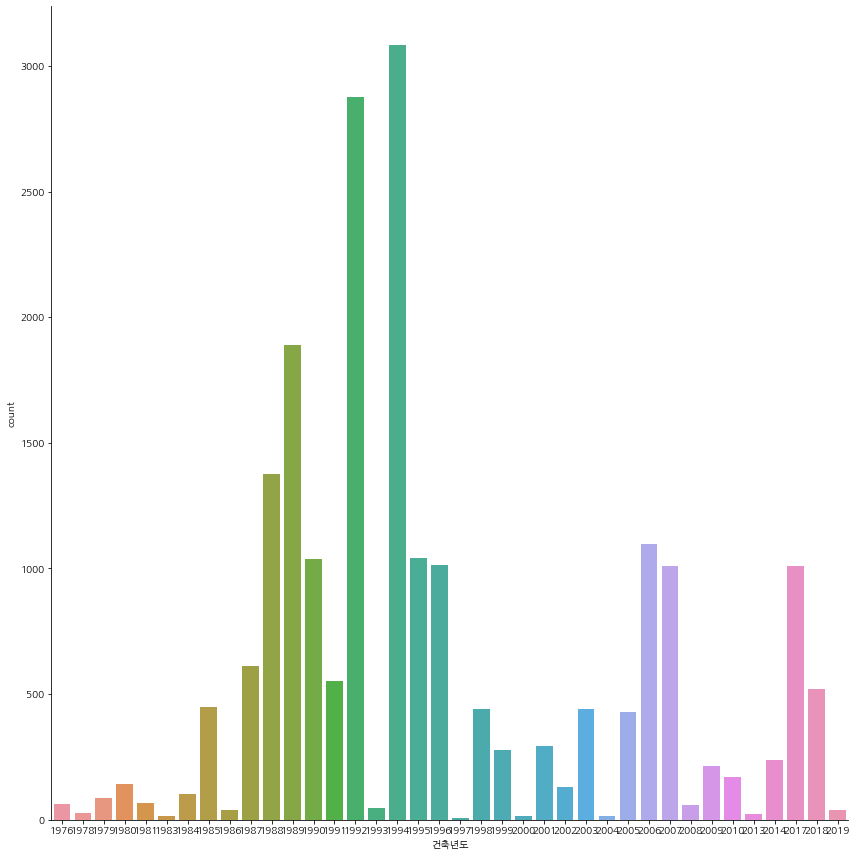

In [21]:
# 4. 어떤 건축년도의 매물이 가장 많나요?
#    * 답 : 1994

# 의도한 풀이 : catplot에서 히스토그램을 배웠으므로, 시각적으로 가장 많은 매물인 1994년도가 가장 많음을 알 수 있습니다.
# 아파트.groupby("건축년도")["건축년도"].count() # 이 코드로도 풀 수 있으나, 수업에서 다루지 않았으므로 넘어갑니다.
sns.catplot(x="건축년도", data=아파트, kind="count", height=12)

In [9]:
# 5. 보증금의 평균은 얼마인가요?
#    * 답 : 14280.575594

평균 = 아파트.mean() # 데이터프레임에 mean 함수를 적용하면 모든 열에 대해 평균 계산을 수행합니다.
평균["보증금(만원)"]

14280.575593900865

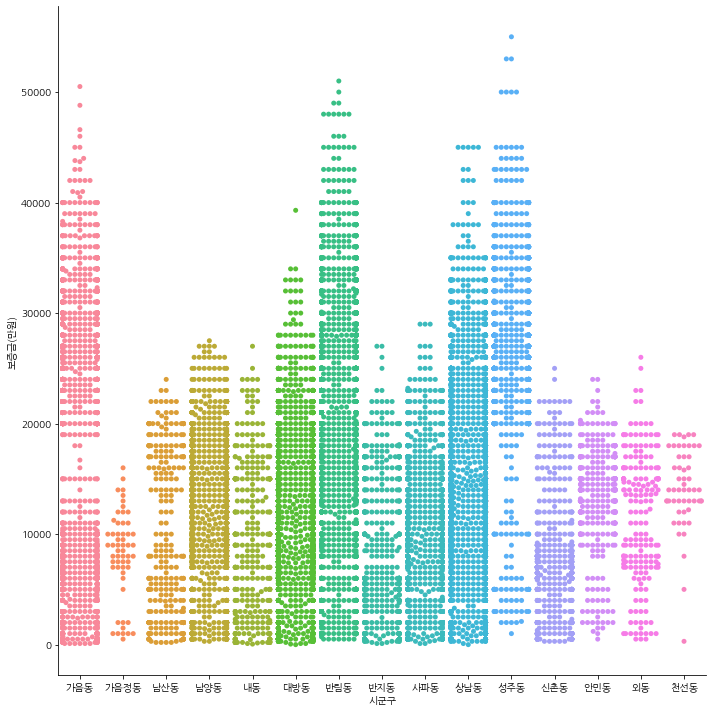

In [10]:
# 6. 시군구별 보증금을 swarmplot으로 출력해보세요.
#     1. 이 차트를 보고 가음정동, 상남동, 남양동 중 매물이 많은 순서대로 적어 보세요.
#     2. 예) 가음정동 > 상남동 > 남양동
#     * 답 : 상남동 > 남양동 > 가음정동

# kind="swwarm" 파라미터를 넘겨주면 swarmplot을 출력할 수 있습니다.
# 가음정동, 상남동, 남양동의 매물 규모를 시각적으로 비교할 수 있습니다.
sns.catplot(x="시군구", y="보증금(만원)", data=아파트, kind="swarm", height=10)

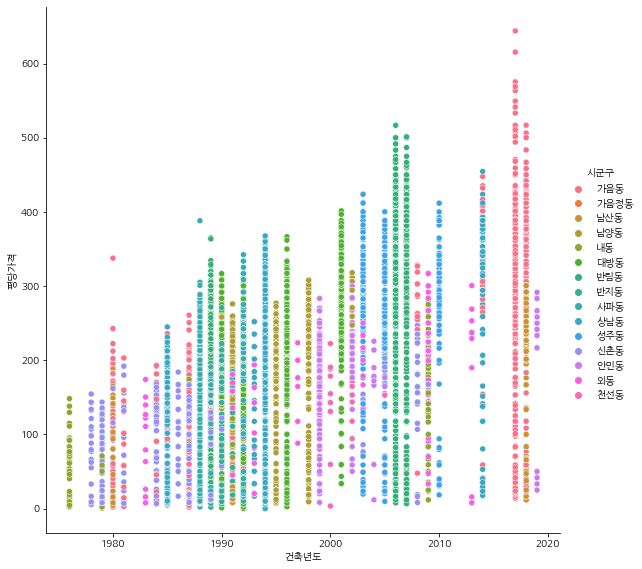

In [11]:
# 7. 시군구별 건축년도에 따른 평당가격을 scatterplot으로 출력해보세요.
#     1. 평당가격이 가장 비싼 데이터가 속한 동은 어디인가요?
#         * 답 : 가음동
#     2. 1번에서 답한 동에서 가장 비싼 데이터가 속한 건축년도는 2000년대 이전인가요, 이후인가요?
#         * 답 : 2000년대 이후

# scatterplot의 세로축이 평당가격이므로, 세로축에서 가장 높은 곳에 데이터가 있는 가음동을 선택하면 됩니다.
sns.relplot(x="건축년도", y="평당가격", hue="시군구", data=아파트, height=8)

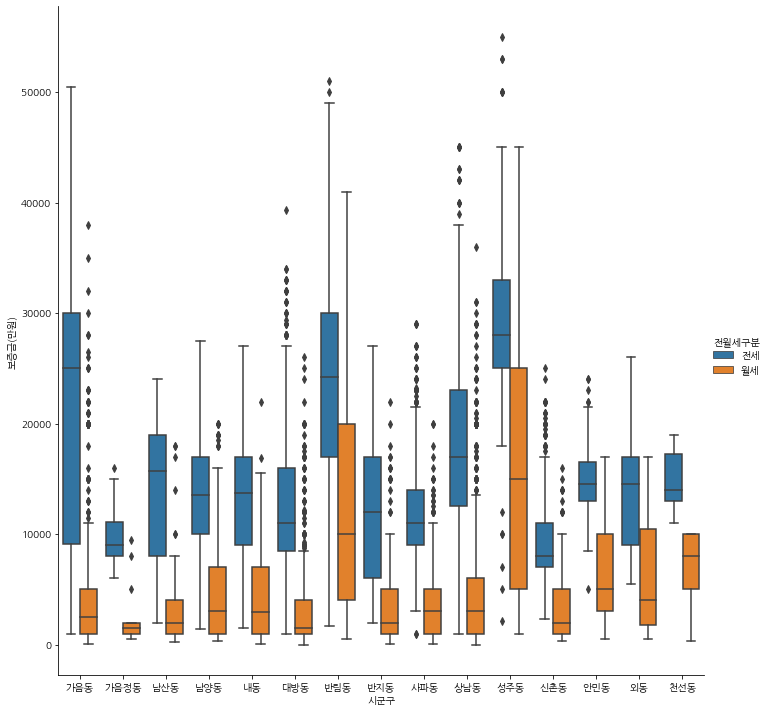

In [12]:
# 8. 시군구를 기준으로 보증금을 나타낸, 색은 전월세구분으로 구분한 boxplot을 그려보세요.
#     1. 전세 데이터에서 1사분위와 3사분위의 차이가 가장 큰, 즉 박스의 넓이가 가장 큰 동은 어디인가요? 
#         * 답 : 가음동
#     2. 월세 데이터에서 1사분위와 3사분위의 차이가 가장 큰, 즉 박스의 넓이가 가장 큰 동은 어디인가요? 
#         * 답 : 성주동


# hue 파라미터를 사용할 수 있으면 풀 수 있습니다.
sns.catplot(x="시군구", y="보증금(만원)", data=아파트, kind="box", hue="전월세구분", height=10)

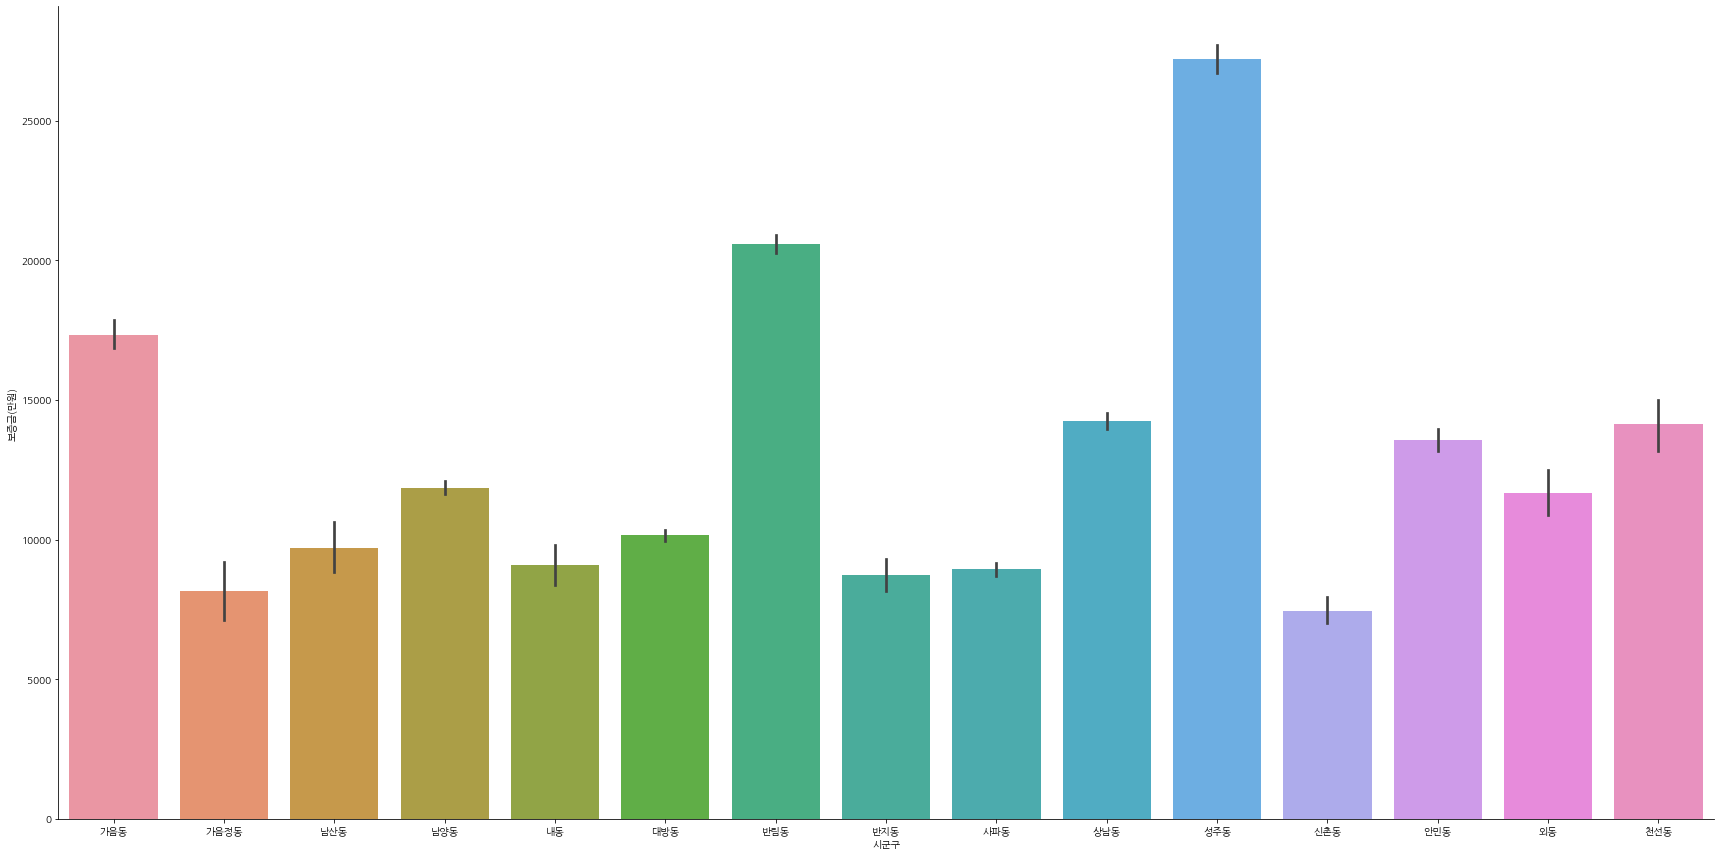

In [13]:
# 9. 시군구에 따른 매물을 막대그래프로 그려보세요.
#     1. 보증금 평균 가격대가 가장 높은 도로명 주소는 어디인가요?
#         * 답 : 외리로

sns.catplot(x="시군구", y="보증금(만원)", data=아파트, kind="bar", height=12, aspect=2)

In [14]:
# 10. 다양한 차트를 지금까지 다루었는데, 지금 다루고 있는 시군구 당 가격 데이터를 시각화하는 데 있어 가장 유용한 차트는 어떤 차트라고 생각하나요?
#     * 답 : 모두 정답. stripplot,swarmplot,boxplot,barplot(막대그래프) 중 하나.
#     1. 왜 그 차트가 이 데이터를 표현하는 데 가장 유용한가요?
#         * 답 : 모두 정답. 아래 중 아무 답이나 쓰면 됩니다.
#           * stripplot, swarmplot : 데이터의 분포를 한 눈에 파악할 수 있습니다.
#           * boxplot : outlier를 포함한 데이터의 수치적 분포를 한 눈에 파악할 수 있습니다.
#           * barplot : 데이터들이 갖는 평균적인 수치를 한 눈에 파악할 수 있습니다.
#     2. 해당 차트 이외에 이 데이터를 표현할 수 있는 다른 차트는 어떤 게 있나요?
#         * 답 : 모두 정답. stripplot,swarmplot,boxplot,barplot(막대그래프).
#     3. 다른 차트들을 선택하지 않은 이유는 무엇인가요?
#         * 답 : 모두 정답. 아래 중 아무 답이나 쓰면 됩니다.
#           * stripplot, swarmplot : 정확한 데이터의 수치를 파악하기 어렵기 때문입니다.
#           * boxplot : boxplot을 이해하기 위한 지식이 필요하고, 한 눈에 파악하기엔 너무 많은 정보가 들어있기 때문입니다.
#           * barplot : barplot으로부터 얻을 수 있는 정보가 제한적이기 때문입니다.

In [15]:
지리_데이터 = gpd.read_file('아파트_지리데이터.json', encoding="euc_kr")
아파트_평균가 = pd.read_excel("아파트_평균가.xlsx")

아파트_평균가

,날짜,가음동,가음정동,남산동,남양동,내동,대방동,반림동,반지동,사파동,상남동,성주동,신촌동,안민동,외동,천선동
0,2015-01-01,11063,0,6000,14245,11375,12549,22809,10583,11892,18155,28533,9785,15250,17000,0
1,2015-02-01,6833,0,13000,13091,11500,13820,21938,9642,12075,17880,31000,9400,14666,14000,0
2,2015-03-01,11187,0,6000,14441,15000,12459,22455,11636,11930,15695,30266,8041,14900,13000,0
3,2015-04-01,8400,12500,8000,13822,12466,11614,24290,19500,11794,19162,31800,8700,18166,16066,16500
4,2015-05-01,9714,0,8250,16110,15000,13143,25225,13000,13500,18838,32857,9000,17750,18000,0
5,2015-06-01,8181,0,0,14077,11500,12103,23214,9000,13277,17230,31833,8200,17000,14700,0
6,2015-07-01,8142,0,8500,13780,0,12398,24750,17000,11850,19123,29083,10900,15000,9000,0
7,2015-08-01,8745,11250,9833,13255,7000,12376,25785,8500,12943,18123,31428,8500,17000,9000,0
8,2015-09-01,9550,12000,0,15382,10875,13375,27142,0,14285,17595,30000,11250,20000,0,0
9,2015-10-01,9437,0,0,16258,14125,14310,25264,15166,12444,20481,34461,12912,17230,0,17933


In [16]:
# * 선택 과제(필수 아님) : 2016년~2019년까지의 아파트 거래 평균가 데이터와 읍면동 지리 데이터가 제공됩니다.
# 이 데이터를 활용해 TimeSliderChoropleth를 그려보세요.
# 참고 : 3주차-3 미세먼지 데이터와 데이터 형태가 동일합니다.
#     1. 기간 내내 높은 가격대를 형성하고 있는 동은 어디인가요?
#         * 답 : 성주동

In [17]:
아파트_평균가["날짜"] = 아파트_평균가["날짜"].astype("datetime64[ns]")
아파트_평균가["날짜"] = 아파트_평균가["날짜"].astype(int) // 10 ** 9
아파트_평균가["날짜"] = 아파트_평균가["날짜"].astype("str")
아파트_평균가 = 아파트_평균가.set_index("날짜")

색_데이터 = {}
빨간색 = "#fc2803"

최댓값 = max(아파트_평균가.max())

for i in range(len(지리_데이터)):
    색_데이터[str(i)] = {}
    for day in 아파트_평균가.index:
        해당_날짜_아파트_평균가 = 아파트_평균가.loc[day][i]
        색_데이터[str(i)][str(day)]= {'color': 빨간색, 'opacity': 해당_날짜_아파트_평균가 / 최댓값}

In [19]:
창원광장 = [35.226367, 128.682232]
m = folium.Map(location=창원광장, zoom_start=11, width=1500, height=600)
TimeSliderChoropleth(data=지리_데이터.to_json(), styledict=색_데이터).add_to(m)

m